In [219]:
import numpy as np
import pandas as pd
# import cvxpy as cvx
from scipy.optimize import minimize
import sympy as sp
import matplotlib.pyplot as plt
import sympy as sp
from functools import reduce
from mpl_toolkits import mplot3d
from scipy.ndimage.interpolation import shift

%matplotlib notebook

# Implementar algoritmos 5.1, 5.2, algo do prob. 5.15

### 5.7

$$ f(x) = (x_1^2 + x_2^2 - 1)^2 + (x_1 + x_2 -1)^2 $$

<IPython.core.display.Javascript object>


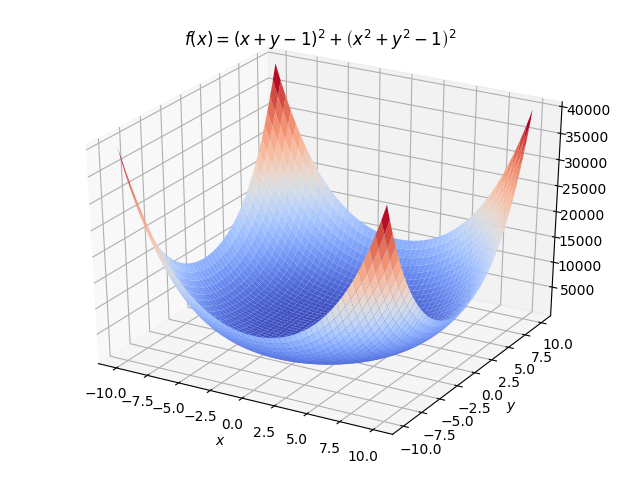

xmin= [  1.00000000e+00   1.66449301e-10]
f(xmin)= 6.4732823155e-18


In [243]:
def loss1(x):
    return (x[0]**2 + x[1]**2 -1)**2 + (x[0] + x[1] -1)**2


nbDims = 2
symbolVec = sp.symbols('a0:%d'%nbDims)
cost = sp.lambdify(symbolVec, loss1(symbolVec), modules=['numpy'])
gradCost = sp.lambdify(symbolVec,[sp.diff(loss1(symbolVec),var) for var in (symbolVec)],'numpy')
hessianCost = sp.lambdify(symbolVec, sp.hessian(loss1(symbolVec),symbolVec),'numpy')

domain = np.linspace(-10,10,1000)
X, Y = np.meshgrid(domain, domain)
Z = cost(X,Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z, cmap=plt.cm.coolwarm)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_title('$f(x)=%s$' % sp.latex(loss1(sp.symbols('x y'))));
plt.tight_layout()
# plt.savefig("lista2/relatorio/figs/loss4.eps", 
# #                bbox_inches='tight', 
# #                transparent=True,
#                pad_inches=0)

res = minimize(loss1, (0,0), method='nelder-mead', options={'xtol': 1e-8, 'disp': False})
loss1Min = res.x
print('xmin=',res.x)
print('f(xmin)=',res.fun)


<IPython.core.display.Javascript object>


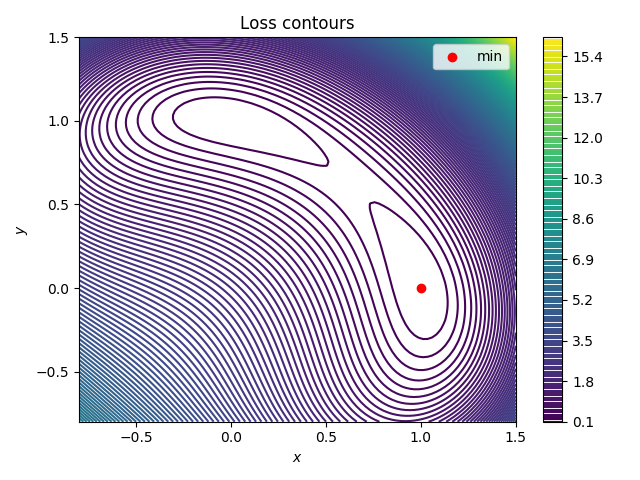

In [245]:
domain = np.linspace(-0.8,1.5,100)
X, Y = np.meshgrid(domain, domain)
Z = cost(X,Y)

plt.figure()
plt.contour(X, Y, Z, 200)
plt.colorbar()
plt.scatter(res.x[0],res.fun,c='r',label='min')
plt.legend()
plt.title('Loss contours')
plt.xlabel('$x$')
plt.ylabel('$y$');
plt.tight_layout()

Como podemos perceber a função não é convexa pois há 2 regiões de mínimo.

In [198]:
def generalDescentMethod(x0, costSymbolic, specificDescentMethod, eps=1e-6, **args):
    
    symbolVec = sp.symbols('a0:%d'%len(x0))
    descentAlgo = specificDescentMethod(symbolVec, costSymbolic, **args)
    nbEvalDict = {}
    params = {}
    delta = np.inf
    xHist = [x0]
    fxHist = [np.NaN]
    
    while np.linalg.norm(delta) > eps:
        
        step, fx, partialNbEvalDict, params, delta = descentAlgo(x0, params)
        nbEvalDict = { k: nbEvalDict.get(k, 0) + partialNbEvalDict.get(k, 0) for k in set(partialNbEvalDict) }
        x0 += step
        xHist.append(x0)
        fxHist.append(fx)

    return xHist, fxHist, nbEvalDict

In [174]:
def steepestDescent(symbolVec, costSymbolic, **args):

    cost = sp.lambdify(symbolVec, costSymbolic(symbolVec), modules=['numpy'])
    gradCost = sp.lambdify(symbolVec,[sp.diff(costSymbolic(symbolVec),var) for var in (symbolVec)],'numpy')
    hessianCost = sp.lambdify(symbolVec, sp.hessian(costSymbolic(symbolVec),symbolVec),'numpy')
    lineSearchMethod = args.pop('lineSearchMethod', noLineSearch)

    def steepestDescentAlgo(x0, params):

        dfx = np.asarray(gradCost(*x0))
        direction = -dfx
        t,f, nbEval, newParams = lineSearchMethod(x0, dfx, direction, cost, params, **args)
        step = t*direction

        return step, f, {'nbFuncEval': nbEval, 'nbGradEval':1}, newParams, step

    return steepestDescentAlgo

In [175]:
def newtonDescent(symbolVec, costSymbolic, **args):

    cost = sp.lambdify(symbolVec, costSymbolic(symbolVec), modules=['numpy'])
    gradCost = sp.lambdify(symbolVec,[sp.diff(costSymbolic(symbolVec),var) for var in (symbolVec)],'numpy')
    hessianCost = sp.lambdify(symbolVec, sp.hessian(costSymbolic(symbolVec),symbolVec),'numpy')
    lineSearchMethod = args.pop('lineSearchMethod', noLineSearch)
    beta = args.pop('beta', 0.3)

    def basicNewtonAlgo(x0, params):

        dfx = np.asarray(gradCost(*x0))
        Hx = np.asarray(hessianCost(*x0))
        eigVals = np.linalg.eigvals(Hx)
        minVal = np.min(eigVals)
        if np.any(eigVals < 0.1):
            beta = 1.5*np.abs(np.min(eigVals))
            Hx = (Hx + beta*np.eye(Hx.shape[0]))/(1+beta)

        HxInv = np.linalg.inv(Hx)
        direction = -HxInv.dot(dfx)        
        t,f, nbEval, newParams = lineSearchMethod(x0, dfx, direction, cost, params, **args)
        step = t*direction

        return step, f, {'nbFunEval': nbEval, 'nbGradEval':1, 'nbHessEval':1}, newParams, step

    return basicNewtonAlgo

In [186]:
def gaussNewtonDescent(symbolVec, costSymbolic, **args):

    cost = sp.lambdify(symbolVec, loss2Vec(symbolVec), modules=['numpy'])
    scalarCost = sp.lambdify(symbolVec,loss2Vec(symbolVec).dot(loss2Vec(symbolVec)), modules=['numpy'])
    jacobian = sp.lambdify(symbolVec, loss2Vec(symbolVec).jacobian(symbolVec), modules=['numpy'])
    lineSearchMethod = args.pop('lineSearchMethod', noLineSearch)
    beta = args.pop('beta', 0.3)

    def gaussNewtonAlgo(x0, params):
        
        fxScalarPrevious = params.pop('Fx',np.inf)
#         print(fxScalarPrevious)
        fx = cost(*x0)
        Jx = jacobian(*x0)
        dfx = 2*Jx.T.dot(fx)
        Hx = 2*Jx.T.dot(Jx)

        L,D = hessianCorrectionMatDav(Hx)
        Dinv = np.linalg.inv(D)
        y = -L.dot(dfx)
        direction = L.T.dot((Dinv).dot(y))
        direction = direction.reshape((np.max(direction.shape),))

        t,f, nbEval, newParams = lineSearchMethod(x0, dfx, direction, scalarCost, params, **args)
        step = t*direction
        
        fxScalar = scalarCost(*(x0+step))
        
        return step, fxScalar, {'nbFunEval': nbEval, 'nbGradEval': dfx.shape[0]}, \
                dict(**newParams, Fx=fxScalar), np.abs(fxScalar-fxScalarPrevious)

    return gaussNewtonAlgo

In [ ]:
def hessianCorrectionMatDav(H):
    n = H.shape[1]
    L = np.zeros(H.shape)
    D = np.zeros(n)
    h00 = 0
    
    if H[0,0] > 0:
        h00 = H[0,0]
    else:
        h00 = 1
    
    for k in range(1,n):
        m = k - 1
        L[m,m] = 1
        if H[m,m] <= 0:
            H[m,m] = h00
        
        for i in range(k,n):
            L[i,m] = - H[i,m]/H[m,m]
            H[i,m] = 0
            for j in range(k,n):
                H[i,j] += L[i,m]*H[m,j]
        
        if H[k,k] > 0 and H[k,k] < h00:
            h00 = H[k,k]
        
    L[-1,-1] = 1
    if H[-1,-1] <= 0:
        H[-1,-1] = h00
    for i in range(n):
        D[i] = H[i,i]

    return L, np.diag(D)

In [196]:
def noLineSearch(x, dfx, vec, cost, params, **args):

    alphaHat = params.pop('alpha', 1)
    fxk = params.pop('fxk', None)
    nbEval = 0
    if fxk is None:
        fxk = cost(*x)
        nbEval += 1
    
    fHat = cost(*(x + alphaHat*vec))
    dfx2alpha = np.vdot(dfx,dfx)*alphaHat
    alpha = (dfx2alpha*alphaHat)/(2*(fHat - fxk + dfx2alpha))
    fx = cost(*(x + alpha*vec))
    
    return alpha, fx, nbEval+2, {'alpha': alpha, 'fxk': fx}
    

In [178]:
def backtrackingLineSearch(x, dfx, vec, cost, params, **args):
    
    domain = args.pop('domain', None)
    fx = args.pop('fx', None)
    alpha = args.pop('alpha', 0.15)
    beta = args.pop('beta', 0.5)
    
    t = 1
    nbEval = 1
    
    if fx is None:
        fx = cost(*x)
        nbEval += 1

    if domain is not None:
        while (x + t*vec <= domain[0]) or (domain[1] <= x + t*vec):
            ptiny
            t *= beta

    f = cost(*(x + t*vec))

    while f > (fx + alpha*t*np.vdot(dfx,vec)):
        t *= beta
        f = cost(*(x + t*vec))
        nbEval += 1

    return t,f, nbEval, {}

## 5.7

In [202]:
x0s = np.array(((4.0,4.0), (4.0,-4.0), (-4.0,4.0), (-4.0,-4.0)))
xHist = {}
fxHist = {}
nbEvalList = {}

print('Using algo 5.1')
for x0 in x0s:
    print()
    print(x0)
    xHist, fxHist, nbEvalList = generalDescentMethod(x0, loss1, steepestDescent,
                                                     lineSearchMethod=backtrackingLineSearch,
                                                     alpha=0.01,beta=0.3)
    print('x min', xHist[-1])
    print('f(x min)', fxHist[-1])
    print('nb evals',nbEvalList)

Using algo 5.1

[ 4.  4.]
x min [ 0.62996042  0.62996042]
f(x min) 0.110118425158
nb evals {'nbGradEval': 10, 'nbFuncEval': 41}

[ 4. -4.]
x min [  6.77192177e-07   9.99999811e-01]
f(x min) 3.81285180688e-13
nb evals {'nbGradEval': 35, 'nbFuncEval': 112}

[-4.  4.]
x min [  9.99999811e-01   6.77192177e-07]
f(x min) 3.81285180706e-13
nb evals {'nbGradEval': 35, 'nbFuncEval': 112}

[-4. -4.]
x min [ 0.62996049  0.62996049]
f(x min) 0.110118425158
nb evals {'nbGradEval': 9, 'nbFuncEval': 37}


## 5.8

In [146]:
x0s = np.array(((4.0,4.0), (4.0,-4.0), (-4.0,4.0), (-4.0,-4.0)))
xHist = {}
fxHist = {}
nbEvalList = {}

print('Using algo 5.2')
for x0 in x0s:
    print()
    print(x0)
    xHist, fxHist, nbEvalList = generalDescentMethod(x0, loss1, steepestDescent,
                                                          lineSearchMethod=noLineSearch)
    print('x min', xHist[-1])
    print('f(x min)', fxHist[-1])
    print('nb evals',nbEvalList)

Using algo 5.2

[ 4.  4.]
This is the final step: [ -5.79410160e-08  -5.79410160e-08]
x min [ 0.62996052  0.62996052]
f(x min) 0.110118425158
nb evals {'nbGradEval': 9, 'nbFuncEval': 19}

[ 4. -4.]
This is the final step: [  3.80018787e-07   7.89315335e-07]
x min [  1.00000064e+00  -1.47046618e-06]
f(x min) 2.32582635969e-12
nb evals {'nbGradEval': 45, 'nbFuncEval': 91}

[-4.  4.]
This is the final step: [  7.89315334e-07   3.80018787e-07]
x min [ -1.47046618e-06   1.00000064e+00]
f(x min) 2.32582636114e-12
nb evals {'nbGradEval': 45, 'nbFuncEval': 91}

[-4. -4.]
This is the final step: [ -7.36184226e-08  -7.36184226e-08]
x min [ 0.62996052  0.62996052]
f(x min) 0.110118425158
nb evals {'nbGradEval': 16, 'nbFuncEval': 33}


## 5.17

In [12]:
x0s = np.array(((4.0,4.0), (4.0,-4.0), (-4.0,4.0), (-4.0,-4.0)))
xHist = {}
fxHist = {}
nbEvalList = {}

print('Using Hessian modified algo 5.3')
for x0 in x0s:
    print()
    print(x0)
    xHist, fxHist, nbEvalList = generalDescentMethod(x0, loss1, newtonDescent,
                                                    lineSearchMethod=backtrackingLineSearch)
    print('x min', xHist[-1])
    print('f(x min)', fxHist[-1])
    print('nb evals',nbEvalList)

Using Hessian modified algo 5.3

[ 4.  4.]
x min [ 0.62996053  0.62996053]
f(x min) 0.110118425158
nb evals {'nbHessEval': 10, 'nbGradEval': 10, 'nbFunEval': 24}

[ 4. -4.]
x min [  1.00000000e+00  -1.61197095e-17]
f(x min) 2.59845033851e-34
nb evals {'nbHessEval': 11, 'nbGradEval': 11, 'nbFunEval': 22}

[-4.  4.]
x min [ -4.95073114e-17   1.00000000e+00]
f(x min) 0.0
nb evals {'nbHessEval': 11, 'nbGradEval': 11, 'nbFunEval': 22}

[-4. -4.]
x min [ 0.62996053  0.62996052]
f(x min) 0.110118425158
nb evals {'nbHessEval': 11, 'nbGradEval': 11, 'nbFunEval': 27}


## 5.20

In [227]:
def loss2(x):
    return (x[0] + 10*x[1])**2 + 5*(x[2] - x[3])**2 + (x[1] - 2*x[2])**4 + 100*(x[0] - x[3])**4

res = minimize(loss2, (0,0,0,0), method='nelder-mead', options={'xtol': 1e-8, 'disp': False})
loss2Min = res.x[0]
print('xmin=',res.x[0])
print('f(xmin)=',res.fun)

xmin= 0.0
f(xmin)= 0.0


### B. Steepest descent

In [204]:
x0s = np.array(((-2.0, -1.0, 1.0, 2.0), (200, -200, 100, -100)))
xHist = {}
fxHist = {}
nbEvalList = {}

print('Using algo 5.2 w/ line search w/ params alpha=0.15,beta=0.5')
for x0 in x0s:
    print()
    print(x0)
    xHist, fxHist, nbEvalList = generalDescentMethod(x0, loss2, steepestDescent, eps=1e-6,
                                                          lineSearchMethod=backtrackingLineSearch)
#                                                      alpha=0.01,beta=0.3)
    print('x min', xHist[-1])
    print('f(x min)', fxHist[-1])
    print('nb evals',nbEvalList)

Using algo 5.2 w/ line search w/ params alpha=0.15,beta=0.5

[-2. -1.  1.  2.]
x min [ 0.01729218 -0.00172863  0.01213036  0.01214012]
f(x min) 5.27195363428e-07
nb evals {'nbGradEval': 12656, 'nbFuncEval': 108660}

[ 200. -200.  100. -100.]
x min [ 0.0173134  -0.00173129  0.01214526  0.01215505]
f(x min) 5.29792024499e-07
nb evals {'nbGradEval': 12984, 'nbFuncEval': 111717}


In [205]:
x0s = np.array(((-2.0, -1.0, 1.0, 2.0), (200, -200, 100, -100)))
xHist = {}
fxHist = {}
nbEvalList = {}
  
print('\n\nUsing algo 5.2 w/ line search w/ params alpha=0.01,beta=0.3')
for x0 in x0s:
    print()
    print(x0)
    xHist, fxHist, nbEvalList = generalDescentMethod(x0, loss2, steepestDescent, eps=1e-6,
                                                          lineSearchMethod=backtrackingLineSearch,
                                                     alpha=0.01,beta=0.3)
    print('x min', xHist[-1])
    print('f(x min)', fxHist[-1])
    print('nb evals',nbEvalList)




Using algo 5.2 w/ line search w/ params alpha=0.01,beta=0.3

[-2. -1.  1.  2.]
x min [ 0.0180028  -0.00180015  0.01262824  0.01263925]
f(x min) 6.1927921754e-07
nb evals {'nbGradEval': 10242, 'nbFuncEval': 59087}

[ 200. -200.  100. -100.]
x min [ 0.01802015 -0.00180142  0.01264036  0.0126514 ]
f(x min) 6.2166154545e-07
nb evals {'nbGradEval': 10702, 'nbFuncEval': 61925}


In [206]:
x0s = np.array(((-2.0, -1.0, 1.0, 2.0), (200, -200, 100, -100)))
xHist = {}
fxHist = {}
nbEvalList = {}

print('\n\nUsing algo 5.2 w/o line search')
for x0 in x0s:
    print()
    print(x0)
    xHist, fxHist, nbEvalList = generalDescentMethod(x0, loss2, steepestDescent, eps=1e-6,
                                                          lineSearchMethod=noLineSearch)
    print('x min', xHist[-1])
    print('f(x min)', fxHist[-1])
    print('nb evals',nbEvalList)



Using algo 5.2 w/o line search

[-2. -1.  1.  2.]
x min [-1.99999998 -1.          1.          1.99999998]
f(x min) 25829.9987493
nb evals {'nbGradEval': 1, 'nbFuncEval': 3}

[ 200. -200.  100. -100.]
x min [ 200. -200.  100. -100.]
f(x min) 835603440000.0
nb evals {'nbGradEval': 1, 'nbFuncEval': 3}


### C. Newton 

In [207]:
x0s = np.array(((-2.0, -1.0, 1.0, 2.0), (200, -200, 100, -100)))
xHist = {}
fxHist = {}
nbEvalList = {}

print('Using algo 5.3 w/ line search w/ params alpha=0.15,beta=0.5')
for x0 in x0s:
    print()
    print(x0)
    xHist, fxHist, nbEvalList = generalDescentMethod(x0, loss2, newtonDescent, eps=1e-6,
                                                          lineSearchMethod=backtrackingLineSearch)
    print('x min', xHist[-1])
    print('f(x min)', fxHist[-1])
    print('nb evals',nbEvalList)

Using algo 5.3 w/ line search w/ params alpha=0.15,beta=0.5

[-2. -1.  1.  2.]
x min [  4.11797486e-06  -4.11797486e-07   2.89051270e-06   2.89051270e-06]
f(x min) 1.69780688961e-21
nb evals {'nbHessEval': 58, 'nbGradEval': 58, 'nbFunEval': 116}

[ 200. -200.  100. -100.]
x min [  4.01913841e-06  -4.01913841e-07   2.82113692e-06   2.82113692e-06]
f(x min) 1.54058405661e-21
nb evals {'nbHessEval': 87, 'nbGradEval': 87, 'nbFunEval': 174}


In [208]:
x0s = np.array(((-2.0, -1.0, 1.0, 2.0), (200, -200, 100, -100)))
xHist = {}
fxHist = {}
nbEvalList = {}
   
print('Using algo 5.3 w/ line search w/ params alpha=0.01,beta=0.3')
for x0 in x0s:
    xHist = {}
    fxHist = {}
    nbEvalList = {}
    print()
    print(x0)
    xHist, fxHist, nbEvalList = generalDescentMethod(x0, loss2, newtonDescent, eps=1e-6,
                                                     lineSearchMethod=backtrackingLineSearch,
                                                     alpha=0.01,beta=0.3)
    print('x min', xHist[-1])
    print('f(x min)', fxHist[-1])
    print('nb evals',nbEvalList)

Using algo 5.3 w/ line search w/ params alpha=0.01,beta=0.3

[-2. -1.  1.  2.]
x min [  4.11797486e-06  -4.11797486e-07   2.89051270e-06   2.89051270e-06]
f(x min) 1.69780688961e-21
nb evals {'nbHessEval': 58, 'nbGradEval': 58, 'nbFunEval': 116}

[ 200. -200.  100. -100.]
x min [  4.01913841e-06  -4.01913841e-07   2.82113692e-06   2.82113692e-06]
f(x min) 1.54058405661e-21
nb evals {'nbHessEval': 87, 'nbGradEval': 87, 'nbFunEval': 174}


In [201]:
x0s = np.array(((-2.0, -1.0, 1.0, 2.0), (200, -200, 100, -100)))
xHist = {}
fxHist = {}
nbEvalList = {}
     
print('Using algo 5.3 w/o line search')
for x0 in x0s:
    xHist = {}
    fxHist = {}
    nbEvalList = {}
    print()
    print(x0)
    xHist, fxHist, nbEvalList = generalDescentMethod(x0, loss2, newtonDescent, eps=1e-6,
                                                          lineSearchMethod=noLineSearch)
    print('x min', xHist[-1])
    print('f(x min)', fxHist[-1])
    print('nb evals',nbEvalList)

Using algo 5.3 w/o line search

[-2. -1.  1.  2.]
x min [-1.56134028 -0.190389    0.95775448  1.24652367]
f(x min) 6247.99546717
nb evals {'nbHessEval': 20, 'nbGradEval': 20, 'nbFunEval': 41}

[ 200. -200.  100. -100.]
x min [ 254.51510187  -77.43336706  101.67907809   43.92145931]
f(x min) 202906076123.0
nb evals {'nbHessEval': 27, 'nbGradEval': 27, 'nbFunEval': 55}


Por que ambos algoritmos (Steepest descent e Newton) quando usam o método sem (backtracking) line search falham miseravelmente na busca pelo mínimo global $[0, 0, 0, 0]$ ?

### D. Gauss-Newton

In [200]:
x0s = np.array(((-2.0, -1.0, 1.0, 2.0), (200, -200, 100, -100)))
xHist = {}
fxHist = {}
nbEvalList = {}

xHist = {}
fxHist = {}
nbEvalList = {}
   
print('\nUsing algo 5.5 w/ line search w/ params alpha=0.01,beta=0.3')
for x0 in x0s:
    print()
    print(x0)
    xHist, fxHist, nbEvalList = generalDescentMethod(x0, loss2, gaussNewtonDescent, eps=1e-6,
                                                     lineSearchMethod=backtrackingLineSearch,
                                                     alpha=0.01,beta=0.3)
    print('x min', xHist[-1])
    print('f(x min)', fxHist[-1])
    print('nb evals',nbEvalList)


Using algo 5.5 w/ line search w/ params alpha=0.01,beta=0.3

[-2. -1.  1.  2.]
x min [-0.03320519  0.00324679 -0.04184367 -0.04253582]
f(x min) 6.08133331337e-05
nb evals {'nbGradEval': 132, 'nbFunEval': 117}

[ 200. -200.  100. -100.]
x min [ 0.03284631 -0.00320794  0.04142506  0.04210216]
f(x min) 5.84631911937e-05
nb evals {'nbGradEval': 212, 'nbFunEval': 235}
